# Project 2: Digit Classification Naive Bayes

**Solution**

# Intro
---
In this project, you'll continue working on your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. 
As always, you're welcome to work on the project in groups and discuss ideas over Slack, but <b> please prepare your own write-up (with your own code). </b>


## Grading
---
 - Make sure to answer every part in every question.
 - There are 6 questions, each equally weighted and an additional bonus question.
 - The extra credit question will be graded based on your attempts at feature engineering and resulting improved accuracy.
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean, well commented,
  -  if the functions or answers are too long.

## Requirements:
---
1. Comment your code.
1. All graphs should have titles, label for each axis, and if needed a legend. It should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning keep things in functions).

## Additional Reading and notes
---
If you're interested, check out these links related to digit recognition:

* Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/
* Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

Finally, if you'd like to get started with Tensorflow, you can read through this tutorial: https://www.tensorflow.org/tutorials/keras/basic_classification. It uses a dataset called "fashion_mnist", which is identical in structure to the original digit mnist, but uses images of clothing rather than images of digits. The number of training examples and number of labels is the same. In fact, you can simply replace the code that loads "fashion_mnist" with "mnist" and everything should work fine.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [2]:
import sklearn
sklearn.__version__

'0.23.2'

Load the data. Notice that the data gets partitioned into training, development, and test sets. Also, a small subset of the training data called mini_train_data and mini_train_labels gets defined, which you should use in all the experiments below, unless otherwise noted.

In [3]:
# Load the digit data from https://www.openml.org/d/554 or from default local location '~/scikit_learn_data/...'
X, Y = fetch_openml(name='mnist_784', return_X_y=True, cache=False)

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


### Question 1: Applying a smoothing using numpy.
---

A common image processing technique is to smooth an image by **blurring**. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian, i.e., the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

1. Implement a simplified Gaussian blur filter by just using the 8 neighboring pixels like this: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values.
1. Choose some weights as a starting point. Produce and evaluate four 1-Nearest Neighbor models by applying your blur filter in these ways:
  1. Do not use the filter
  1. Filter the training data but not the dev data
  1. Filter the dev data but not the training data
  1. Filter both training data and dev data
1. Show the accuracies of the four models evaluated as described. What do you see? Can you explain why this is?
1. Experiment with weights that makes one model's accuracy at least 0.9.

Notes:
* Train on the (filtered) mini train set.
* Evaluate performance on the (filtered) dev set.
* A good trick to simplify your code is to use numpy's pad function to add 0s around your original array so you don't have to deal with "edge cases".
* In addition, you can use numpy to multiply and sum slices of two arrays.
* [This notebook](https://colab.research.google.com/drive/1eJXTQLtREXQjQIsLOA9uCrBl6B049-pO) might help shows some example numpy code.
* In general, [numpy operations will be much faster than for loops](https://colab.research.google.com/drive/1KJI4JtuIqVdyZHTTe_mAlKYA5XdLFp3_). 
* There are other Guassian blur filters available, for example in `scipy.ndimage.filters`. You are welcome to experiment with those, but in this question, please implement your own.

In [4]:
def Q1():
    
### STUDENT START ###
    raw_train_images = mini_train_data.reshape(mini_train_data.shape[0], 28, 28) 
    raw_dev_images   = dev_data.reshape(mini_train_data.shape[0], 28, 28) 
    mean_filter = 1/9 * np.ones((3,3))
    padded_train_images_unshaped = np.pad(raw_train_images, pad_width=1, mode='constant', constant_values=0)[1:1001]
    padded_dev_images_unshaped   = np.pad(raw_dev_images, pad_width=1, mode='constant', constant_values=0)[1:1001]
    mean_filter = 1/9 * np.ones((3,3))
    def filter_images(unfiltered_images, custom_filter):
        filtered_images = np.copy(unfiltered_images)
        for count, im in enumerate(unfiltered_images):
            for x in range(0,28):
                x_min = x
                x_max = x+3
                for y in range(0,28):
                    y_min = y
                    y_max = y+3
                    filtered_images[count][x,y] = sum(sum(im[x_min:x_max, y_min:y_max]*custom_filter))
        final_images = filtered_images.reshape(len(filtered_images),-1) 
        return final_images
    
    filtered_train_images = filter_images(padded_train_images_unshaped, mean_filter)
    filtered_dev_images   = filter_images(padded_dev_images_unshaped, mean_filter)
    
    padded_train_images = padded_train_images_unshaped.reshape(len(padded_train_images_unshaped),-1) 
    padded_dev_images   = padded_dev_images_unshaped.reshape(len(padded_dev_images_unshaped),-1) 

    model_a = KNeighborsClassifier(n_neighbors=1) # Do not use the filter
    model_b = KNeighborsClassifier(n_neighbors=1) # Filter the training data but not the dev data
    model_c = KNeighborsClassifier(n_neighbors=1) # Filter the dev data but not the training data
    model_d = KNeighborsClassifier(n_neighbors=1) # Filter both training data and dev data

    accuracy_of_models = []

    model_a.fit(padded_train_images, mini_train_labels)
    predicted_labels_a = model_a.predict(padded_dev_images) 
    accuracy_of_models.append(["a",1 - sum(dev_labels != predicted_labels_a)/len(predicted_labels_a)])

    model_b.fit(filtered_train_images, mini_train_labels)
    predicted_labels_b = model_b.predict(padded_dev_images) 
    accuracy_of_models.append(["b", 1 - sum(dev_labels != predicted_labels_b)/len(predicted_labels_b)])

    model_c.fit(padded_train_images, mini_train_labels)
    predicted_labels_c = model_c.predict(filtered_dev_images) 
    accuracy_of_models.append(["c", 1 - sum(dev_labels != predicted_labels_c)/len(predicted_labels_c)])

    model_d.fit(filtered_train_images, mini_train_labels)
    predicted_labels_d = model_d.predict(filtered_dev_images) 
    accuracy_of_models.append(["d", 1 - sum(dev_labels != predicted_labels_d)/len(predicted_labels_d)])

    for model_num, acc in accuracy_of_models:
        print(f"Model {model_num} predicted an accuracy of {acc*100:.1f}%")
    
    # TESTING FILTERS
    print("\nMany filters were tested to try to get a 90% accuracy.")
    test_filters = [np.array([[-1, -1, -1],
                              [-1, 7, -1],
                              [-1, -1, -1]]), 
                    np.array([[0, -1, 0],
                             [-1, 1, -1],
                             [0, -1, 0]]),
                    np.array([[-1, -1, -1],
                             [-1, 1, -1],
                             [-1, -1, -1]]),
                    np.array([[1, 0, -1],
                              [2, 0, -2],
                              [1, 0, -1]]),
                    np.array([[1, 2, 1],
                              [0, 0, 0],
                              [-1, -2, -1]])]
    filter_names = ["Laplacian Filter (7)", "Laplacian Filter (1)", "Laplacian Filter (w/ diagonals)", "Vertical Edge Detection", "Horizontal Edge Detection"]
    test_filter_dict = {filter_names[k]:test_filters[k] for k in range(5)}
    for filt_name, filt  in test_filter_dict.items():
        filtered_train_images_test = filter_images(padded_train_images_unshaped, filt)
        filtered_dev_images_test   = filter_images(padded_dev_images_unshaped, filt)

        model_test = KNeighborsClassifier(n_neighbors=1)
        model_test.fit(padded_train_images, mini_train_labels)
        predicted_labels_test = model_test.predict(filtered_dev_images_test) 
        test_accuracy =  1 - sum(dev_labels != predicted_labels_test)/len(predicted_labels_test)

        print(f"Test filter {filt_name}: \n{filt[0]}\n{filt[1]}\n{filt[0]} \nhad accuracy of {test_accuracy*100:.1f}%\n")
### STUDENT END ###

Q1()

Model a predicted an accuracy of 88.4%
Model b predicted an accuracy of 72.8%
Model c predicted an accuracy of 73.4%
Model d predicted an accuracy of 90.5%

Many filters were tested to try to get a 90% accuracy.
Test filter Laplacian Filter (7): 
[-1 -1 -1]
[-1  7 -1]
[-1 -1 -1] 
had accuracy of 26.0%

Test filter Laplacian Filter (1): 
[ 0 -1  0]
[-1  1 -1]
[ 0 -1  0] 
had accuracy of 4.2%

Test filter Laplacian Filter (w/ diagonals): 
[-1 -1 -1]
[-1  1 -1]
[-1 -1 -1] 
had accuracy of 4.4%

Test filter Vertical Edge Detection: 
[ 1  0 -1]
[ 2  0 -2]
[ 1  0 -1] 
had accuracy of 63.2%

Test filter Horizontal Edge Detection: 
[1 2 1]
[0 0 0]
[1 2 1] 
had accuracy of 71.0%



### Question 2: Modeling your data and experimenting with different Naive Bayes models. 
---

1. Produce two Naive Bayes models and evaluate their performances.  Recall that Naive Bayes estimates P(feature|label), where each label is a categorical, not a real number.
  1. For the first model, map pixel values to either 0 or 1, representing white or black - you should pre-process the data or use `    model_1 = BernoulliNB(binarize=0.1)
` parameter to set the white/black separation threshold to 0.1.  Use `BernoulliNB` to produce the model.
  1. For the second model, map pixel values to either 0, 1, or 2, representing white, gray, or black - you should pre-process the data, seting the white/gray/black separation thresholds to 0.1 and 0.9.  Here you'll likely need to implement a `trianarize` helper function. Since we are going beyond the binary representation of our features, you should use `MultinomialNB` to produce the model.
1. Show the Bernoulli model accuracy and the Multinomial model accuracy.
1. Does the multinomial version improve the results? Why or why not?

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.



In [5]:
# Solution with binarization by explicit binarize function

def Q2():

### STUDENT START ###
    model_1 = BernoulliNB(binarize=0.1)
    model_1.fit(mini_train_data, mini_train_labels)
    prediction_labels_1 = model_1.predict(dev_data)

    model_1_acc =  1 - sum(dev_labels != prediction_labels_1)/len(prediction_labels_1)
    print(f"Bernoulli NB Model had accuracy of {model_1_acc*100:.1f}%")
    def trianarize(images, lower_thresh, upper_thresh):
        new_images = np.copy(images)
        for count, image in enumerate(images):
            new_image = image
            new_image[image<=lower_thresh] = 0
            new_image[image>lower_thresh] = 1
            new_image[image>upper_thresh] = 2                                     
            new_images[count] = new_image
        return new_images
    
    tri_train_data = trianarize(mini_train_data, 0.1, 0.9)
    model_2 = MultinomialNB()
    model_2.fit(tri_train_data, mini_train_labels)
    prediction_labels_2 = model_2.predict(dev_data)

    model_2_acc =  1 - sum(dev_labels != prediction_labels_2)/len(prediction_labels_2)
    print(f"Multinomial NB Model had accuracy of {model_2_acc*100:.1f}%")
### STUDENT END ###

Q2()

Bernoulli NB Model had accuracy of 81.4%
Multinomial NB Model had accuracy of 79.7%


ANSWER: The multinomial NB model does not always improve accuracy of an classification model 

### Question 3: Applying the grid search technique.
1. Search across several values of the LaPlace smoothing parameter (alpha) to find its effect on a Bernoulli Naive Bayes model's performance.  Show the accuracy at each alpha value.
1. What is the best value for alpha? What is the accuracy when alpha is near 0? Is this what you'd expect?

Notes:
* Set binarization threshold to 0.
* Train on the mini train set.
* Evaluate performance by 5-fold cross-validation. 
* Use `GridSearchCV(..., ..., cv=..., scoring='accuracy', iid=False)` to vary alpha and evaluate performance by cross-validation.
* Cross-validation is based on partitions of the training data, so results will be a bit different than if you had used the dev set to evaluate performance.



In [6]:
def Q3(alphas):

### STUDENT START ###
    model_B = BernoulliNB(binarize=0.1)
    model_grids = GridSearchCV(model_B, alphas, scoring='accuracy')
    model_grids.fit(mini_train_data, mini_train_labels) 
    predictions = model_grids.predict(dev_data) 
    
    for test_al, test_score in zip(alphas['alpha'], model_grids.cv_results_['mean_test_score']):
        print(f"alpha value {test_al:6} had an accuracy of {test_score*100:.1f}%")            
                               
### STUDENT END ###

alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
Q3(alphas)

alpha value  1e-10 had an accuracy of 82.3%
alpha value 0.0001 had an accuracy of 82.6%
alpha value  0.001 had an accuracy of 82.6%
alpha value   0.01 had an accuracy of 82.9%
alpha value    0.1 had an accuracy of 81.9%
alpha value    0.5 had an accuracy of 82.3%
alpha value    1.0 had an accuracy of 81.5%
alpha value    2.0 had an accuracy of 81.6%
alpha value   10.0 had an accuracy of 79.1%


ANSWER: alpha value of 0.01 was the best parameter with an accuracy of 82.9%. The accuracy when it is near zero is 82.3%, which is still fairly close to the rest of the models produced, but not as accurate as the others. This is expected because an alpha value close to zero means there is no smoothing of the data. 


    ### Question 4: Experimenting with Gaussian Naive Bayes
---
1. Produce a model using Guassian Naive Bayes, which is intended for real-valued features, and evaluate performance. You will notice that it does not work so well. 
1. Diagnose and explain the problem.
1. Apply a simple fix so that the model accuracy is around the same as for a Bernoulli Naive Bayes model. 
1. Show the model accuracy before your fix and the model accuracy after your fix.  
1. Explain your solution.

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.
* Take a look at var_smoothing argument for GaussianNB.
* Feel free to  examine theta and sigma to better understand what's happening. In general though, **it is not a good idea to mess with internal variables of the model**. These are stored in the model's `theta_` and `sigma_` attributes.

In [7]:
def Q4():

### STUDENT END ###
    model_1 = GaussianNB()
    model_1.fit(mini_train_data, mini_train_labels)
    score_1 = model_1.score(dev_data, dev_labels)
    print(f"Original Gaussian Naive Bayes model had score {score_1*100:.1f}%")

    model_2 = GaussianNB(var_smoothing=.1)
    model_2.fit(mini_train_data, mini_train_labels)
    score_2 = model_2.score(dev_data, dev_labels)
    print(f"Gaussian Naive Bayes model with var_smoothing set to 0.1 had score {score_2*100:.1f}%")

### STUDENT END ###

Q4()

Original Gaussian Naive Bayes model had score 39.8%
Gaussian Naive Bayes model with var_smoothing set to 0.1 had score 45.7%


ANSWER: Adding the var_smoothing parameter helps the accuracy of the model because it smooths the distribution curve of the samples. This causes the model to look at more samples that are further from the sample mean so that it trains from a wide range of samples.

### Question 5: Naive Bayes as a generative model
---
Because Naive Bayes produces a generative model, you can use it to generate digit images.

1. Produce a Bernoulli Naive Bayes model and then use it to generate a 10x10 grid with 10 example images of each digit. Each pixel output will be either 0 or 1: randomly generating a number and then comparing it to the estimated probability of the pixel being either 0 or 1.  Show the grid.
1. How do the generated digit images compare to the training digit images?

Notes:
* You can use np.random.rand() to generate random numbers from a uniform distribution.
* The estimated probability of each pixel being 0 or 1 is stored in the model's `feature_log_prob_` attribute. You can use `np.exp()` to convert a log probability back to a probability.



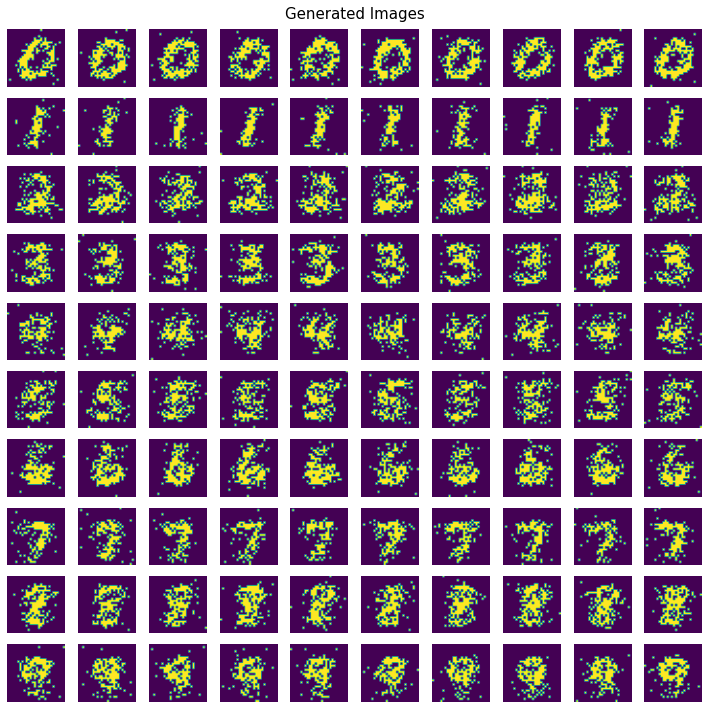

In [8]:
def Q5(num_examples):

### STUDENT START ###
    model_gen = BernoulliNB(binarize=0.1)
    model_gen.fit(mini_train_data, mini_train_labels)
    prediction_labels = model_gen.predict(dev_data)
    feature_predictions = np.exp(model_gen.feature_log_prob_)
    num_examples = 10
    fig, axes = plt.subplots(10, num_examples, figsize = (num_examples, 10))

    for label, feature in enumerate(feature_predictions):
        rand_images = np.random.rand(10,784)
        binary_images = np.where(rand_images > feature, 0, 1)
    #     print(binary_images.shape)
        for num_plot, im in enumerate(binary_images):
            plotting_image = im.reshape(28,28)
            ax = axes[label, num_plot]
            ax.imshow(plotting_image)
            ax.axis('off')
    fig.suptitle("Generated Images", fontsize=15)
    fig.tight_layout()

### STUDENT END ###

Q5(10)

ANSWER: The generate digit images are close to the training digit images. They are very grainy, but still fairly distinguishable in most cases. 

### Question 6: Model Calibraiton
---
Recall that:
 * a **strongly calibrated** classifier is rougly 90% accurate when it says it is 90% accurate. The model's estimated posterior probability of the predicted class is indeed 0.9. 
 * A **weakly calibrated** classifier is more accurate when it "says" it is more accurate. The actual accuracy is higher when the model's estimated posterior probability is higher.
 * A **poorly calibrated** classifier has no positive correlation between the model's estimate posterior probability and the actual accuracy.

1. Produce a Bernoulli Naive Bayes model.  
1. Evaluate performance: 
  1. Partition the dev set into several buckets based on the estimated posterior probabilities of the predicted classes (predict_proba)
    - Think of it as a bin in a histogram, where each bin groups a range of estimated posterior probabilities of the predicted classes (predict_proba).
    - Then estimate the actual accuracy the classifier achieved for each bucket. 
    - So, for each prediction:
       - Find the bucket whose range includes the estimated posterior probability, 
       - and update "correct" and "total" counters accordingly. 
       - Show the accuracy for each bucket.
1. How would you characterize the calibration for this Bernoulli Naive Bayes model according to the definitions above?

Notes:
* Set LaPlace smoothing (alpha) to the optimal value (from part 8).
* Set binarization threshold to 0.
* Train on the mini train set.
* Evaluate perfromance on the dev set.



In [9]:
def Q6(buckets, correct, total):
    
### STUDENT START ###
    model = BernoulliNB(binarize=0, alpha=0.01)
    model.fit(mini_train_data, mini_train_labels)
    prediction_probs = model.predict_proba(dev_data)
    for count, prediction in enumerate(prediction_probs):
        pred_label = np.argmax(prediction)
        act_label = int(dev_labels[count])
        max_prob = np.max(prediction)        
        for bucket_num, bucket in enumerate(buckets):
            if max_prob <= bucket:
                total[bucket_num] += 1
                if pred_label == act_label:
                    correct[bucket_num] += 1
                break
    accuracys = []
    for cor, tot in zip(correct,total):
        try:
            accuracys.append(cor/tot)
        except:
            accuracys.append(1)

    for bucket, acc, corr, tot in zip(buckets, accuracys, correct, total):
        print(f"Bucket {bucket:15} had accuracy of {acc*100:6.2f}% | {corr}/{tot}")
### STUDENT END ###

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

Q6(buckets, correct, total)

Bucket             0.5 had accuracy of 100.00% | 0/0
Bucket             0.9 had accuracy of  34.38% | 11/32
Bucket           0.999 had accuracy of  39.44% | 28/71
Bucket         0.99999 had accuracy of  56.60% | 30/53
Bucket       0.9999999 had accuracy of  57.14% | 28/49
Bucket     0.999999999 had accuracy of  80.00% | 44/55
Bucket   0.99999999999 had accuracy of  68.75% | 33/48
Bucket 0.9999999999999 had accuracy of  84.62% | 33/39
Bucket             1.0 had accuracy of  94.03% | 614/653


ANSWER: I think this is a weakly calibrated classifier because it is more aaccurate when it says it is more accurate, but it is not 90% accurate when it says it is 90% accurate. This is shown by the second bucket. 

### Question 7 EXTRA CREDIT: Feature generation
---
1. Design new features to see if you can produce a Bernoulli Naive Bayes model with better performance.
1. Show the accuracy of a model based on the original features and the accuracy of the model based on the new features.

**Note that improving results is actually hard.**

Here are a few ideas to get you started:
- Try summing or averaging the pixel values in each row.
- Try summing or averaging the pixel values in each column.
- Try summing or averaging the pixel values in each square block. (pick various block sizes)
- Try implementing [*maxpool*](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling) features, taking a rolling maximum over sub-regions of a the image. 
- In any case, you can either transform the original data or add new "features" to it.

Notes:
* Train on the mini train set (enhanced to comprise the new features).
* Evaulate performance on the dev set.
* Ensure that your code is well commented.

In [38]:
def Q7():

### STUDENT START ###
    def max_pool_images(raw_images):
        pooled_images = np.ones([1000,7,7])
        for count, im in enumerate(raw_images):
            for x in range(0,7):
                x_min = x*4
                x_max = (x*4) + 3
                for y in range(0,7):
                    y_min = y*4
                    y_max = (y*4) + 3
                    new_val = sum(sum(im[x_min:x_max, y_min:y_max]))
                    if new_val > 10:
                        pooled_images[count][x,y] = 10
                    else:
                        pooled_images[count][x,y] = new_val
        final_images = pooled_images.reshape(len(pooled_images),-1) 

        return final_images
    
    def binary_pool_images(raw_images):
        pooled_images = np.ones([1000,7,7])
        for count, im in enumerate(raw_images):
            for x in range(0,7):
                x_min = x*4
                x_max = (x*4) + 3
                for y in range(0,7):
                    y_min = y*4
                    y_max = (y*4) + 3
                    new_val = sum(sum(im[x_min:x_max, y_min:y_max]))
                    if new_val == 0:
                        pooled_images[count][x,y] = 0
                    else:
                        pooled_images[count][x,y] = 1
        final_images = pooled_images.reshape(len(pooled_images),-1) 

        return final_images
    
    max_pooled_train = max_pool_images(raw_train_images)
    max_pooled_dev   = max_pool_images(raw_dev_images)
    
    binary_pooled_train = binary_pool_images(raw_train_images)
    binary_pooled_dev   = binary_pool_images(raw_dev_images)
    
    model_max = BernoulliNB(binarize=0, alpha=0.01)
    model_max.fit(max_pooled_train, mini_train_labels)
    max_model_score = model_max.score(max_pooled_dev, dev_labels)
    
    model_bin = BernoulliNB(binarize=0, alpha=0.01)
    model_bin.fit(binary_pooled_train, mini_train_labels)
    model_bin_score = model_bin.score(binary_pooled_dev, dev_labels)

    print("2 different filtering methods were attempted")
    print(f"For a max pool with a max of 10, the model had an accuracy of score {max_model_score*100:.2f}%")
    print(f"For a binary pool, the model had an accuracy of score {model_bin_score*100:.2f}%")
    
### STUDENT END ###

Q7()

2 different filtering methods were attempted
For a max pool with a max of 10, the model had an accuracy of score 72.50%
For a binary pool, the model had an accuracy of score 72.50%
